<a href="https://colab.research.google.com/github/boangri/neuraluniversity/blob/master/HW17.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Исходный ноутбук №17

In [43]:
# Статический вывод графики (графики отображаются в той ячейке, в которой используется plt.show())
%matplotlib inline

import pandas as pd # импортируем библиотеку обработки и анализа данных pandas
import matplotlib.pyplot as plt # Импортируем модуль pyplot библиотеки matplotlib для построения графиков
from tensorflow.keras import utils # Импортируем модуль utils библиотеки tensorflow.keras для получения OHE-представления
import numpy as np # Импортируем библиотеку numpy
from keras.preprocessing.text import Tokenizer, text_to_word_sequence,tokenizer_from_json 

from sklearn.preprocessing import StandardScaler, LabelEncoder # Импортируем библиотеку StandardScaler и LabelEncoder
from sklearn.cluster import KMeans # Импортируем библиотуке KMeans для кластеризации
from sklearn.metrics.cluster import homogeneity_score
from sklearn.manifold import TSNE
import time
import os

from tensorflow.keras.models import Sequential, Model # Полносвязная модель
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Reshape, Conv2DTranspose, Dropout, SpatialDropout1D, BatchNormalization, Embedding, Flatten, Activation # Слои для сети
from tensorflow.keras.preprocessing.sequence import pad_sequences # Метод для работы с последовательностями
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.datasets import mnist

## 
Загружаем базу


In [44]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Кластеризация корзин интернет-магазина


In [45]:
df = pd.read_csv('/content/drive/My Drive/Базы/online_carts.csv') # Читаем данные из загруженной базы

In [46]:
df.head()

,Unnamed: 0,Валовая прибыль,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,NaN,Период: Февраль 2019 г. - Август 2019 г.,NaN,NaN,NaN
1,NaN,Показатели: Стоимость продажи (руб.)(С НДС),Количество(Базовых ед.),NaN,NaN
2,NaN,Группировки строк: ЗаказПокупателя.Дата оправк...,ЗаказПокупателя.ID заказа (Элементы),Номенклатура.Наименование (Элементы),NaN
3,NaN,Отборы:\nПодразделение В списке (estel.m-cosme...,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN


In [47]:
# Посмотрим на уникальные значения каждого из безымянных столбцов
print(df['Unnamed: 0'].unique(),
      df['Unnamed: 2'].unique(),
      df['Unnamed: 3'].unique(),sep='\n')

[nan]
[nan ' Количество(Базовых ед.)' ' ЗаказПокупателя.ID заказа (Элементы)'
 ... '3472' '7616' '2731']
[nan ' Номенклатура.Наименование (Элементы)' 'Количество' 'Базовых ед.'
 '9' '1' '4' '797' '162' '3' '2' '5' '7' '8' '6' '49' '10' '34' '11' '25'
 '20' '13' '17' '29' '1130' '148' '12' '40' '14' '50' '68' '51' '23' '22'
 '16' '1096' '105' '124' '139' '19' '15' '26' '30' '21' '504' '28' '575'
 '60' '61' '18' '80' '942' '44' '188' '24' '1375' '147' '137' '33' '597'
 '82' '37' '860' '47' '825' '27' '45' '229' '887' '113' '58' '104' '38'
 '1751' '134' '138' '1214' '341' '168' '81' '88' '1074' '150' '32' '52'
 '43' '1023' '64' '72' '31' '39' '1237' '254' '46' '289' '1938' '456'
 '132' '2689' '599' '1771' '181' '322' '77' '556' '90' '256' '42' '57'
 '35' '883' '118' '1078' '145' '2749' '36' '1360' '85' '893' '214' '692'
 '119' '1533' '239' '650' '93' '70' '1551' '158' '78' '102' '780' '291'
 '41' '1278' '140' '48' '161' '1127' '122' '94' '978' '98' '769' '92'
 '159' '720' '69' '56' '1648'

In [48]:
new = df.drop(['Unnamed: 0'], axis =1)                             # Этот столбец не несет никакой информации, так что выкинем его
new.insert(0, column='Дата', value = [x for x in range(len(new))]) # Вставим новую колонку "Дата", чтобы из базы вытащить временные данные в отдельную колонку
new = new.fillna('unknown')                                        # Все Nan заполним строкой "unknown", чтобы не выскакивало ошибок

In [49]:
new[new['Валовая прибыль'].str.contains("MCOSM")] # MCOSM - флаг начала корзины

,Дата,Валовая прибыль,Unnamed: 2,Unnamed: 3,Unnamed: 4
10,10,MCOSM13113,26236,9,unknown
22,22,MCOSM13113,1929,4,unknown
166,166,MCOSM4885,350,2,unknown
168,168,MCOSM4996,9436,4,unknown
172,172,MCOSM5963,8625,6,unknown
...,...,...,...,...,...
99589,99589,MCOSM33527,2714,6,unknown
99596,99596,MCOSM33529,3145,9,unknown
99603,99603,MCOSM33530,3030,12,unknown
99616,99616,MCOSM33537,2259,2,unknown


In [50]:
date_list = list(new[new['Валовая прибыль'].str.contains("\d\d.\d\d.2019")].index) # Здесь будут лежать все индексы строк, где есть информация в формате даты

indx=0
for i in range(len(new)):                       # Проходимся по каждой строке базы
  if i in date_list:                            # Если индекс находится среди тех, где есть формат даты
    indx = i                                    # Обновляем текущий индекс
  new['Дата'][i] = new['Валовая прибыль'][indx] # Присваиваем текущий индекс всем последующим строкам, пока не наткнемся на новый индекс-дату


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [51]:
new

,Дата,Валовая прибыль,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,Период: Февраль 2019 г. - Август 2019 г.,Период: Февраль 2019 г. - Август 2019 г.,unknown,unknown,unknown
1,Период: Февраль 2019 г. - Август 2019 г.,Показатели: Стоимость продажи (руб.)(С НДС),Количество(Базовых ед.),unknown,unknown
2,Период: Февраль 2019 г. - Август 2019 г.,Группировки строк: ЗаказПокупателя.Дата оправк...,ЗаказПокупателя.ID заказа (Элементы),Номенклатура.Наименование (Элементы),unknown
3,Период: Февраль 2019 г. - Август 2019 г.,Отборы:\nПодразделение В списке (estel.m-cosme...,unknown,unknown,unknown
4,Период: Февраль 2019 г. - Август 2019 г.,unknown,unknown,unknown,unknown
...,...,...,...,...,...
99627,02.09.2019 0:00:00,Kapous Блеск-шампунь Brilliants gloss 250 мл,347,1,unknown
99628,02.09.2019 0:00:00,Крем-бальзам-архитектор волос для восстановле...,345,1,unknown
99629,02.09.2019 0:00:00,Услуга доставки DPD до двери,350,1,unknown
99630,02.09.2019 0:00:00,Шампунь разглаживающий с глиоксиловой кислот...,304,1,unknown


In [52]:
new = new.drop(new[new['Дата'].str.contains('Период')].index,axis = 0)           # Выкинем превьюшные строки
new = new.drop(new[new['Валовая прибыль'].str.contains('unknown')].index,axis=0) # Выкинем пустые строки между корзинами
new = new.drop(new[new['Валовая прибыль']==new['Дата']].index)                   # Выкинем строки-даты, которые находятся в столбце корзин
new.reset_index(inplace=True)                                                    # Обновим индекс
new = new.drop('index',axis=1)                                                   # Выкинем ненужную, образовавшуюся после предыдущей операции колонку

In [53]:
cart_list = list(new[new['Валовая прибыль'].str.contains("MCOSM")].index)        # Здесь будут лежать все индексы строк, где строка содержит флаг начала корзины
cafre_list = list(new[new['Валовая прибыль'].str.contains("CAFRE")].index)       # Здесь будут лежать все индексы строк, где строка содержит флаг CAFRE 

Взглянем на распаршенную базу

In [54]:
new.head(20)

,Дата,Валовая прибыль,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,01.01.2019 0:00:00,MCOSM13113,26236,9,unknown
1,01.01.2019 0:00:00,CONTURA (HS61) машинка для стрижки волос,9059,1,unknown
2,01.01.2019 0:00:00,Holika Holika Универсальный гель 99% алоэ вера...,539,1,unknown
3,01.01.2019 0:00:00,Kapous Бальзам-уход для придания объема Volume...,181,1,unknown
4,01.01.2019 0:00:00,Kapous Шампунь для придания объема Volume up 3...,181,1,unknown
5,01.01.2019 0:00:00,XPERT (HS71) машинка для стрижки волос,12989,1,unknown
6,01.01.2019 0:00:00,ЛП ТНА САВАЖ ПАНАШ 250 мл,988,1,unknown
7,01.01.2019 0:00:00,перчатки (50 пар) винил размер S черные,319,1,unknown
8,01.01.2019 0:00:00,Услуга доставки DPD до двери,990,1,unknown
9,01.01.2019 0:00:00,Услуга доставки СДЭК,990,1,unknown


In [55]:
carts = []                     # Здесь будут лежать все корзины 
cart=[]                        # В этом списке будет текущая корзина
i=0                            # Счетчик для прохождения по базе
val = new['Валовая прибыль']   # Будем работать с этим столбцом
allPositions = []              # Создаем пустой список позиций

while i!=len(new):             # Пока не дойдем до конца списка

  if i in cart_list:           # Если счетчик в списке индексов-корзин

    if i!=cart_list[-1]:       # Проверяем, если это не последний индекс-флаг
      ind = cart_list.index(i) # Текущему индексу-флагу присваиваем значение конкретно этой корзины

      # Пробегаемся дальше по счетчику до момента, когда он не будет равен следующему в списке индексу-флагу
      # Если условия соблюдаются, то закидываем следующую строку в текущую корзину
      # Инкремент счетчика
      while i<cart_list[ind+1]-1:
        cart.append(val[i+1])
        allPositions.append(val[i+1]) 
        i+=1 
      
    else:                      # Если же текущий индекс-флаг последний в списке

      # Пробегаемся дальше по счетчику до момента, когда он не будет равен концу списка всех строк в столбце-1
      # Если условия соблюдаются, то закидываем следующую строку в текущую корзину
      # Инкремент счетчика
      while i<(len(new)-1):
        cart.append(val[i+1])
        allPositions.append(val[i+1]) 
        i+=1

    carts.append(cart)         # Закидываем корзину в список всех корзин
    cart=[]                    # Очищаем корзину
    
  else:
    i+=1                       # Если счетчик не в списке корзин, то инкрементируем
 


In [56]:
len(carts)

13567

In [57]:
items = 0
for cart in carts:
    for item in cart:
        items += 1
print(items)

85617


In [58]:
print(len(carts)==len(cart_list))   # Проверка, если у нас количество корзин совпадает с количеством флагов корзин
print('Количество всех позиций: ', len(allPositions)) 
print('Пример того, что лежит в корзине: ', carts[0])

True
Количество всех позиций:  85617
Пример того, что лежит в корзине:  ['CONTURA (HS61) машинка для стрижки волос', 'Holika Holika Универсальный гель 99% алоэ вера, 250 мл', 'Kapous Бальзам-уход для придания объема Volume up 350 мл', 'Kapous Шампунь для придания объема Volume up 350 мл', 'XPERT (HS71) машинка для стрижки волос', 'ЛП ТНА САВАЖ ПАНАШ 250 мл', 'перчатки (50 пар) винил размер S черные', 'Услуга доставки DPD до двери', 'Услуга доставки СДЭК']


In [59]:
for i in range(10):
    print(carts[i])

['CONTURA (HS61) машинка для стрижки волос', 'Holika Holika Универсальный гель 99% алоэ вера, 250 мл', 'Kapous Бальзам-уход для придания объема Volume up 350 мл', 'Kapous Шампунь для придания объема Volume up 350 мл', 'XPERT (HS71) машинка для стрижки волос', 'ЛП ТНА САВАЖ ПАНАШ 250 мл', 'перчатки (50 пар) винил размер S черные', 'Услуга доставки DPD до двери', 'Услуга доставки СДЭК']
['OLLIN SERVICE LINE Увлаж. Бальзам для волос 1000 мл', 'OLLIN SERVICE LINE Шампунь.-стабилизатор рН 3.5 1000 мл', 'Масло-уход для светлых волос  ESTEL PRIMA BLONDE 100 мл.', 'Услуга доставки Почта России', '/101 Крем-краска ESTEL PRINCESS ESSEX пепельный', '/44 Крем-краска ESTEL PRINCESS ESSEX медный', '0/00 Стойкая крем-краска чистый тон', '0/00N Крем-краска ESTEL PRINCESS ESSEX нейтральный', '0/11 Крем-краска ESTEL PRINCESS ESSEX синий', '0/22 Крем-краска ESTEL PRINCESS ESSEX зеленый', '0/33 Крем-краска ESTEL PRINCESS ESSEX желтый', '0/33 Стойкая крем-краска интенсивный золотистисты', '0/55 Крем-краска

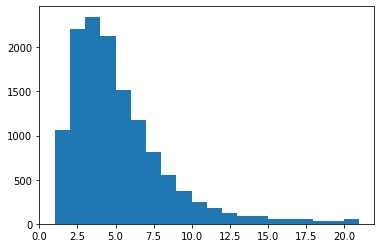

In [20]:
# Отобразим гистограмму размеров корзин
plt.hist([len(c) for c in carts], 20, [1, 21])
plt.show()

In [60]:
allPositions[:10]

['CONTURA (HS61) машинка для стрижки волос',
 'Holika Holika Универсальный гель 99% алоэ вера, 250 мл',
 'Kapous Бальзам-уход для придания объема Volume up 350 мл',
 'Kapous Шампунь для придания объема Volume up 350 мл',
 'XPERT (HS71) машинка для стрижки волос',
 'ЛП ТНА САВАЖ ПАНАШ 250 мл',
 'перчатки (50 пар) винил размер S черные',
 'Услуга доставки DPD до двери',
 'Услуга доставки СДЭК',
 'OLLIN SERVICE LINE Увлаж. Бальзам для волос 1000 мл']

In [61]:
len(allPositions)

85617

In [62]:
labelEncoder = LabelEncoder()  # Создаем объект LabelEncoder 
labelEncoder.fit(allPositions) # Обрабатываем все имеющиеся позиции товаров

LabelEncoder()

In [63]:
maxPositionsCount = max(labelEncoder.transform(allPositions))+1 # Посчитаем количество уникальных товаров
print(maxPositionsCount)                                        # Отобразим это количество

6663


In [64]:
cartsIndexes = [labelEncoder.transform(c) for c in carts] # Создаем список индексов для каждой корзины

In [65]:
n = 0                  # Укажем номер корзины
print(carts[n])        # Отобразим содержимое этой корзины
print(cartsIndexes[n]) # Отобразим соответствующие индексы

['CONTURA (HS61) машинка для стрижки волос', 'Holika Holika Универсальный гель 99% алоэ вера, 250 мл', 'Kapous Бальзам-уход для придания объема Volume up 350 мл', 'Kapous Шампунь для придания объема Volume up 350 мл', 'XPERT (HS71) машинка для стрижки волос', 'ЛП ТНА САВАЖ ПАНАШ 250 мл', 'перчатки (50 пар) винил размер S черные', 'Услуга доставки DPD до двери', 'Услуга доставки СДЭК']
[1503 1732 1804 1987 2962 4226 6274 5656 5660]


In [66]:
'''
  Функция преобразования вектора по приницпу bag of words
    Входные параметры:
      - trainVector - исходный вектор индексов слов
      - wordsCount - установленная длинна вектора
    Функция возращает: 
      - сформированный вектор из 0 и 1
'''
def changeXTo01(trainVector, wordsCount):
  out = np.zeros(wordsCount)                   # Создаем вектор из нулей длинной wordsCount
  for x in trainVector:                        # Пробегаем по всем индексам в trainVector
    out[x] = 1                                 # Изменяем на 1 значение out в позиции текущего индекса 
  return out                                   # Возвращаем сформированный вектор


'''
  Функция преобразования выборки (обучающей или проверочной) по принципе Bag of words
    Входные параметры:
      - trainSet - выборка
      - wordsCount - установленная длинна вектора
    Функция возращает: 
      - сформированная выборка из 0 и 1
'''
def changeSetTo01(trainSet, wordsCount):
  out = []                                     # Создаем пустой список  
  for x in trainSet:                           # Пробегаем по всем элемента выборки
    out.append(changeXTo01(x, wordsCount))     # Получаем вектор Bag of words для текущего элемента    
  return np.array(out)                         # Возрващаем сформированную выборку

In [67]:
carts01 = changeSetTo01(cartsIndexes, maxPositionsCount) # Создаем выборку по принципу bag of words

In [68]:
n = 5                  # Указываем номер корзины
print(carts[n])        # Выводим содержимое корзины
print(cartsIndexes[n]) # Выводим список соответствующих индексов
print(carts01[n])      # Выводим соответсвующий список bag of words

['10/65 светлый блондин фиолетово-красный DLSe', '10/76 светлый блондин коричнево-фиолетовый DLSe', 'Бальзам DE LUXE для выравнивания структуры 1000 мл.', 'Бальзам DE LUXE стабилизатор цвета 1000 мл.', 'Восстанавливающий эликсир LuxeOil 100 мл.', 'Разглаживающее масло для интенсивного блеска 100 мл. Wella', 'Шампунь DE LUXE интенсивное очищение 1000 мл.', 'Шампунь DE LUXE стабилизатор цвета 1000 мл.']
[ 211  239 3092 3093 3323 5181 5742 5743]
[0. 0. 0. ... 0. 0. 0.]


### Кластеризация

In [69]:
%%time
cur_time = time.time()
clustersCount = 8                                  # Указываем количество кластеров
kmean = KMeans(clustersCount)                        # Создаем объект KMeans
kmean.fit(carts01)                                   # Производим кластеризацию набора carts01
labels = kmean.labels_                               # Сохраняем метки в переменную labels

npCarts = np.array(carts)                            # Преобразуем список корзин в numpy
print('Время обработки: ', round(time.time() - cur_time,2),'c')

Время обработки:  74.39 c
CPU times: user 1min 25s, sys: 5.42 s, total: 1min 30s
Wall time: 1min 14s


In [27]:
print(labels)                                                   # Отображаем метки кластеров
clusterSize = [sum(labels==i) for i in range(0, clustersCount)] # Создадим список размеров каждого кластера

# Выведем номер кластера и его размер
for i, s in enumerate(clusterSize):
  print(i, s)

[1 2 1 ... 7 7 0]
0 874
1 3839
2 115
3 1
4 45
5 361
6 3329
7 5003


In [28]:
def getCluster(x):
  clasterSize = x.shape[0]                           # Берем размер кластера
  sumX = np.sum(x, axis=0)                           # Считаем сумму кластера по позициям
  sumX /= clasterSize                                # Смотрим насколько часто конкретная позиция появляется в данном кластере
  
  positions = []                                     # Создаем пустой список позиций
  positionValues = []                                # Создаем пустой список значений
  
  for i in range(sumX.shape[0]):                     # Пробегаем по всем имеющимся примерам товаров
    if (sumX[i] > 0):                                # Если товар присутствует в данном кластере
      position = labelEncoder.inverse_transform([i]) # Получаем обратный энкодер
      positions.append(position)                     # Добавляем позицию в список позиций 
      positionValues.append(sumX[i])                 # В списк значений добавляем количество данной позиции в текущем кластере
  
  return positions, positionValues                   # Возвращаем список позиций кластера и количество каждой позиции

In [29]:
for clusterNumber in range(len(clusterSize)):                # Пробегаем по всем кластерам
  if (clusterSize[clusterNumber] > 5):                       # Если размер кластера больше 5
    pos, posVal = getCluster(carts01[labels==clusterNumber]) # Получаем позиции и их количество в текущем кластере
    print("Покупок:", clusterSize[clusterNumber])            # Выводим размер текущего кластера
    print("Позиций:", len(pos))                              # Выводим общее число позиций в текущем кластере
    pos = np.array(pos)                                      # Преобразуем в numpy
    posVal = np.array(posVal)                                # Преобразуем в numpy
    indexes = posVal > 0.6                                   # Берем индексы тех позиций, доля которых составляет больше 20%
    indexedPos = pos[indexes]                                # Выбираем эти позиции из pos
    indexedPosVal = posVal[indexes]                          # Выбираем доли этих позиций

    # Отображаем долю позиции и название самой позиции
    for i in range(len(indexedPos)):
      print(round(100*indexedPosVal[i]), "% ", indexedPos[i], sep="")

    print()
    print()

Покупок: 874
Позиций: 2072
100.0% ['Услуга доставки DPD до двери']


Покупок: 3839
Позиций: 3439
100.0% ['Услуга доставки СДЭК']


Покупок: 115
Позиций: 3140
84.0% ['Услуга доставки Почта России']
82.0% ['Услуга доставки СДЭК']


Покупок: 45
Позиций: 1456
64.0% ['5/0 Стойкая крем-краска светлый шатен']
62.0% ['6/0 Стойкая крем-краска темный блонд']
62.0% ['7/0 Стойкая крем-краска блонд']
69.0% ['Окислительная эмульсия  6% Londa 1000 мл.']
62.0% ['Шампунь для окрашенных волос Color Radiance 1000 мл. Londa']


Покупок: 361
Позиций: 926
68.0% ['Бальзам для интенсивного увлажнения волос OTIUM AQUA 1000 мл.']
95.0% ['Шампунь для интенсивного увлажнения волос OTIUM AQUA 1000 мл.']


Покупок: 3329
Позиций: 3586
100.0% ['Услуга доставки Почта России']


Покупок: 5003
Позиций: 5091




Готово разбиение на 1 классов
Готово разбиение на 2 классов
Готово разбиение на 3 классов
Готово разбиение на 4 классов
Готово разбиение на 5 классов
Готово разбиение на 6 классов
Готово разбиение на 7 классов
Готово разбиение на 8 классов
Готово разбиение на 9 классов
Готово разбиение на 10 классов
Готово разбиение на 11 классов
Готово разбиение на 12 классов
Готово разбиение на 13 классов
Готово разбиение на 14 классов
CPU times: user 19min 53s, sys: 1min 36s, total: 21min 30s
Wall time: 16min 48s


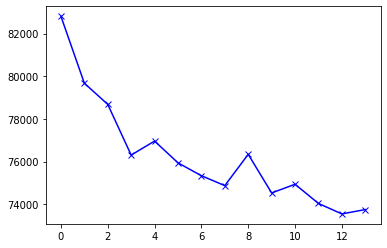

In [ ]:
%%time
cost = []
for i in range(1,15):
  kmean = KMeans(i*1) # *20
  kmean.fit(carts01)
  cost.append(kmean.inertia_)
  print("Готово разбиение на ", i*1, " классов", sep="")
    
plt.plot(cost, 'bx-')

In [ ]:
max(labels)

7

In [30]:
# Разбиение на 280 классов
for clusterNumber in range(max(labels)):                     # Пробегаем по всем значениям
    if (clusterSize[clusterNumber] > 5):                     # Если размер кластера больше 5
      pos, posVal = getCluster(carts01[labels==clusterNumber]) # Получаем позиции и их количество в текущем кластере
      print("Покупок:", clusterSize[clusterNumber])            # Выводим размер текущего кластера
      print("Позиций:", len(pos))                              # Выводим общее число позиций в текущем кластере
      pos = np.array(pos)                                      # Преобразуем в numpy
      posVal = np.array(posVal)                                # Преобразуем в numpy
      indexes = posVal > 0.2                                   # Берем индексы тех позиций, доля которых составляет больше 20%
      indexedPos = pos[indexes]                                # Выбираем эти позиции из pos
      indexedPosVal = posVal[indexes]                          # Выбираем доли этих позиций

      # Отображаем долю позиции и название самой позиции
      for i in range(len(indexedPos)):
        print(round(100*indexedPosVal[i]), "% ", indexedPos[i], sep="")

      print()
      print()

Покупок: 874
Позиций: 2072
100.0% ['Услуга доставки DPD до двери']


Покупок: 3839
Позиций: 3439
100.0% ['Услуга доставки СДЭК']


Покупок: 115
Позиций: 3140
32.0% ['AQUATIKA Маска-смузи  увлажнение Likato 250мл']
25.0% ['AQUATIKA Софт-Бальзам увлажнение Likato 250мл']
25.0% ['AQUATIKA Софт-Шампунь с алоэ Likato 250мл']
25.0% ['Kapous Кератин бальзам серии Magic Keratin 1000 мл']
28.0% ['Kapous Кератин шампунь серии Magic Keratin Professional 1000 мл']
21.0% ['WELLNESS Минеральный шампунь с витаминами Likato 250мл']
41.0% ['Бальзам для ежедневного применения 1000 мл. Curex Classic']
23.0% ['Бальзам для интенсивного увлажнения волос OTIUM AQUA 1000 мл.']
21.0% ['Деликатный шампунь для окрашенных волос OTIUM COLOR LIFE 1000 мл.']
25.0% ['Интенсивная маска для поврежденных волос 500 мл.']
22.0% ['Кератиновая вода для волос ESTEL KERATIN 100 мл.']
23.0% ['Кератиновая маска для волос ESTEL KERATIN 250 мл.']
22.0% ['Кератиновый шампунь для волос ESTEL KERATIN 250 мл.']
23.0% ['Масло Velvet O

# LIGHT 

Используйте готовый ноутбук с кластеризацией базы покупок интернет магазина:



### Удалите из выборки все строки про доставку (автоматически, уже из carts)



In [70]:
carts_ = [[item for item in cart if not item.startswith('Услуга доставки')] for cart in carts]

In [71]:
len(carts_) # новый список содержит корзины, из которых удалены доставки

13567

Число позиций после удаления доставок:

In [72]:
items = 0
for cart in carts_:
    for item in cart:
        items += 1
print(items)

76716


Пересоздадим списки cartsIndexes and carts01:

In [73]:
carts, carts_ = carts_, carts # теперь в carts_ будут корзины с доставками
cartsIndexes = [labelEncoder.transform(c) for c in carts] 
carts01 = changeSetTo01(cartsIndexes, maxPositionsCount)

Проверим что доставка удалилась.

In [74]:
n = 0                  # Указываем номер корзины
print(carts[n])        # Выводим содержимое корзины
print(cartsIndexes[n]) # Выводим список соответствующих индексов
print(carts01[n])      # Выводим соответсвующий список bag of words

['CONTURA (HS61) машинка для стрижки волос', 'Holika Holika Универсальный гель 99% алоэ вера, 250 мл', 'Kapous Бальзам-уход для придания объема Volume up 350 мл', 'Kapous Шампунь для придания объема Volume up 350 мл', 'XPERT (HS71) машинка для стрижки волос', 'ЛП ТНА САВАЖ ПАНАШ 250 мл', 'перчатки (50 пар) винил размер S черные']
[1503 1732 1804 1987 2962 4226 6274]
[0. 0. 0. ... 0. 0. 0.]


### Выведите две гистограммы
- Распределения размеров классов - сколько корзин
- Распределение количества уникальных позиций в классе



Кластеризуем по-новой (мы изменили carts01)

Готово разбиение на 1 классов
Готово разбиение на 2 классов
Готово разбиение на 3 классов
Готово разбиение на 4 классов
Готово разбиение на 5 классов
Готово разбиение на 6 классов
Готово разбиение на 7 классов
Готово разбиение на 8 классов
Готово разбиение на 9 классов
Готово разбиение на 10 классов
Готово разбиение на 11 классов
Готово разбиение на 12 классов
CPU times: user 16min 49s, sys: 1min 16s, total: 18min 6s
Wall time: 14min 25s


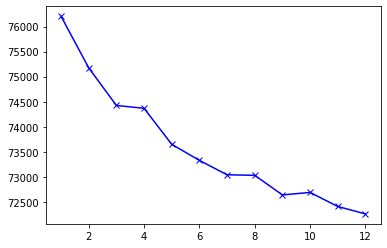

In [ ]:
%%time
cost = []
for i in range(1, 13):
  kmean = KMeans(i) # *20
  kmean.fit(carts01)
  cost.append(kmean.inertia_)
  print("Готово разбиение на ", i, " классов", sep="")
    
plt.plot(list(range(1, 13)), cost, 'bx-')


Хорошо кластеризовать на 3, 7 или 9 кластеров.

In [75]:
%%time
clustersCount = 9                                   # Указываем количество кластеров
kmean = KMeans(clustersCount)                        # Создаем объект KMeans
kmean.fit(carts01)                                   # Производим кластеризацию набора carts01
labels = kmean.labels_                               # Сохраняем метки в переменную labels

npCarts = np.array(carts) 

CPU times: user 1min 35s, sys: 5.58 s, total: 1min 40s
Wall time: 1min 22s


In [76]:
len(carts), len(carts01)

(13567, 13567)

In [77]:
print(labels)                                                   # Отображаем метки кластеров
clusterSize = [sum(labels==i) for i in range(0, clustersCount)] # Создадим список размеров каждого кластера

# Выведем номер кластера и его размер
for i, s in enumerate(clusterSize):
    print(i, s)

[2 0 2 ... 5 2 2]
0 64
1 336
2 12119
3 81
4 72
5 310
6 1
7 583
8 1



---


Распределения размеров классов - сколько корзин

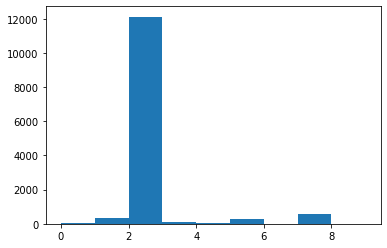

In [78]:
_ = plt.hist(labels, clustersCount, [0, clustersCount])



---

Распределение количества уникальных позиций в классе

Возьмем самый многочисленный класс - №2:

In [79]:
n = 2 # номер класса
cluster = [cartsIndexes[i] for i in range(len(carts)) if labels[i] == n]
items = []
for i in cluster:
    items.extend(i)

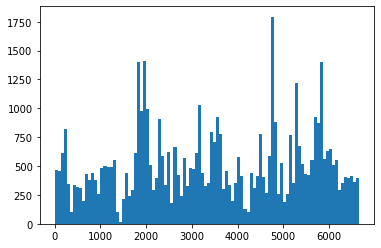

In [80]:
_ = plt.hist(items, 100)

Замечу, что представление этой величины в виде гистограммы малоинформативно и некорректно, так как уникальных позиций у нас более 6000, и в одну корзину(гистограммы) будут попадать совершенно не связанные между собой продукты.

### Напишите продвинутую функцию визуализации одного выбранного класса
- Размер класса
- Количество уникальных позиций
- Позиции, которые есть минимум в 20% корзин
- Уникальные слова в описаниях позиций, которые встречаются минимум в 20% позиций, для отслеживания моно-брендовых и моно-товарных закупок


Функция для вывода размера класса:

In [41]:
def printSize(cluster):
    """
    cluster: список корзин (в любом формате) 
    """
    print("Cluster has %d carts" % len(cluster))

In [81]:
n = 2 # номер класса
cluster = [cartsIndexes[i] for i in range(len(carts)) if labels[i] == n]
items = []
for i in cluster:
    items.extend(i)
print("Cluster #%d has %d carts" % (n , len(cluster)))

Cluster #2 has 12119 carts


In [87]:
def printNumberUniqPositions(cluster):
    items = []
    for cart in cluster:
        items.extend(cart)
    uniqs = set()
    [uniqs.add(item) for item in items]
    print("Uniq positions:", len(uniqs))

In [88]:
printNumberUniqPositions(cluster)

Uniq positions: 6059


Позиции, которые есть минимум в 20% корзин:

In [89]:
def printPopularPositions(cluster, level=0.2):
    N = int(level*len(cluster)) 
    items = []
    for cart in cluster:
        items.extend(cart)
    uniqs = set()
    [uniqs.add(item) for item in items]
    qty = {id: 0 for id in uniqs} # словарь id -> в скольких корзинах встречается позиция id
    for cart in cluster:
        for id in cart:
            qty[id] += 1
    ids20 = [id for id in uniqs if qty[id] > N] # список ids которые встретились более чем в N корзинах
    print('Позиции, которые есть минимум в %d%% корзин:' % int(100*level), ids20)

In [93]:
printPopularPositions(cluster, level=0.2)

Позиции, которые есть минимум в 20% корзин: []


In [94]:
printPopularPositions(cluster, level=0.02)

Позиции, которые есть минимум в 2% корзин: [5700, 5825, 6001]


In [95]:
printPopularPositions(cluster, level=0.01)

Позиции, которые есть минимум в 1% корзин: [1820, 1823, 1934, 2500, 3138, 3145, 3487, 3585, 3586, 3587, 3599, 4529, 4792, 4793, 4797, 4798, 5166, 5300, 5318, 5700, 5825, 5843, 6001]


Уникальные слова в описаниях позиций, которые встречаются минимум в 20% позиций, для отслеживания моно-брендовых и моно-товарных закупок

In [101]:
maxWordsCount = 10000
tok = Tokenizer(num_words=maxWordsCount, filters='!"#$%&()*+,-–—./:;<=>?@[\\]^_`{|}~\t\n\xa0', lower=True, split=' ', oov_token='unknown', char_level=False)
positions = []
for p in carts:
    positions.extend(p)
tok.fit_on_texts(positions)         
items = list(tok.word_index.items())

In [102]:
items[:10]

[('unknown', 1),
 ('мл', 2),
 ('для', 3),
 ('волос', 4),
 ('крем', 5),
 ('шампунь', 6),
 ('1000', 7),
 ('краска', 8),
 ('с', 9),
 ('estel', 10)]

In [103]:
len(items)

5888

In [104]:
positionIds = tok.texts_to_sequences(positions) 

In [105]:
positionIds[:10]

[[4290, 4291, 967, 3, 729, 4],
 [337, 337, 763, 122, 1313, 326, 1057, 14, 2],
 [15, 17, 112, 3, 204, 95, 196, 430, 270, 2],
 [15, 6, 3, 204, 95, 196, 430, 270, 2],
 [3588, 3589, 967, 3, 729, 4],
 [364, 1288, 3360, 3361, 14, 2],
 [420, 74, 478, 575, 458, 515, 587],
 [18, 170, 125, 557, 17, 3, 4, 7, 2],
 [18, 170, 125, 6, 242, 657, 53, 37, 7, 2],
 [71, 112, 3, 120, 4, 10, 107, 98, 16, 2]]

In [106]:
uniqPositions = set()
[uniqPositions.add(p) for p in positions]
print("Distinct positions:", len(uniqPositions))

Distinct positions: 6658


In [112]:
def printPopularWords(cluster, level=0.2):
    pos_count = 0
    for cart in cluster:
        pos_count += len(cart) # Находим полное число позиций в кластере
    N = int(level*pos_count) # Пороговое количество позиций для слова.
    qty = {id: 0 for id in range(1, len(tok.word_index.items())+1)} # словарь id -> в скольких позициях встречается слово id
    for item in positionIds:
        for id in item:
            qty[id] += 1
    ids20 = [id for id in range(1, len(tok.word_index.items())+1) if qty[id] > N] # список ids слов, которые встретились более чем в N позициях
    words = [tok.index_word[id] for id in ids20]
    print('слова, которые есть минимум в %d%% позиций:' % int(100*level), words)

In [113]:
printPopularWords(cluster, level=0.2)

слова, которые есть минимум в 20% позиций: ['мл', 'для', 'волос', 'крем', 'шампунь', '1000', 'краска']


**Искомая продвинутая функция**

In [115]:
def printAdvanced(cluster):
    printSize(cluster)
    printNumberUniqPositions(cluster)
    printPopularPositions(cluster)
    printPopularWords(cluster)

In [116]:
printAdvanced(cluster)

Cluster has 12119 carts
Uniq positions: 6059
Позиции, которые есть минимум в 20% корзин: []
слова, которые есть минимум в 20% позиций: ['мл', 'для', 'волос', 'крем', 'шампунь', '1000', 'краска']


# PRO задание. Вариант 1
Задание по кластеризации слов в Embedding пространстве
- Возьмите любую текстовую базу (например, базу книг писателей из наших  прошлых занятий)
- Сделайте классификатор с embedding слоем в начале (не Bag of words)
- Обучите классификатор
- Возьмите предобученный embedding слой и перегоните все слова из полного словаря в embedding пространство
- Запустите кластеризацию
- Выведите устойчивые классы слов
- Проведите для разного числа классов и разной размерности embedding пространства
- Напишите выводы


### 1. Возьмите любую текстовую базу (например, базу книг писателей из наших  прошлых занятий)


In [ ]:
# Загружаем базу писателей
!wget https://xland.ru/uai/hw04/writers.zip
!unzip -q 'writers.zip' -d /content/texts 

--2020-11-30 19:17:39--  https://xland.ru/uai/hw04/writers.zip
Resolving xland.ru (xland.ru)... 198.211.125.59
Connecting to xland.ru (xland.ru)|198.211.125.59|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8960427 (8.5M) [application/zip]
Saving to: ‘writers.zip’

writers.zip         100%[===================>]   8.54M  53.5MB/s    in 0.2s    

2020-11-30 19:17:40 (53.5 MB/s) - ‘writers.zip’ saved [8960427/8960427]



In [ ]:
def readText(fileName): # Объявляем функции для чтения файла. На вход отправляем путь к файлу
  f = open(fileName, 'r')        # Задаем открытие нужного файла в режиме чтения
  text = f.read()                # Читаем текст
  text = text.replace("\n", " ") # Переносы строки переводим в пробелы
  
  return text                    # Возвращаем текст файла

className = ["О. Генри", "Стругацкие", "Булгаков", "Саймак", "Фрай", "Брэдберри"] # Объявляем интересующие нас классы
nClasses = len(className) # Считаем количество классов

# Формирование обучающей выборки по листу индексов слов
# (разделение на короткие векторы)
def getSetFromIndexes(wordIndexes, xLen, step): # функция принимает последовательность индексов, размер окна, шаг окна
  xSample = [] # Объявляем переменную для векторов
  wordsLen = len(wordIndexes) # Считаем количество слов
  index = 0 # Задаем начальный индекс 

  while (index + xLen <= wordsLen):# Идём по всей длине вектора индексов
    xSample.append(wordIndexes[index:index+xLen]) # "Откусываем" векторы длины xLen
    index += step # Смещаеммся вперёд на step
    
  return xSample
  
# Формирование обучающей и проверочной выборки
# Из двух листов индексов от двух классов
def createSetsMultiClasses(wordIndexes, xLen, step): # Функция принимает последовательность индексов, размер окна, шаг окна

  # Для каждого из 6 классов
  # Создаём обучающую/проверочную выборку из индексов
  nClasses = len(wordIndexes) # Задаем количество классов выборки
  classesXSamples = []        # Здесь будет список размером "кол-во классов*кол-во окон в тексте*длину окна (например, 6 по 1341*1000)"
  for wI in wordIndexes:      # Для каждого текста выборки из последовательности индексов
    classesXSamples.append(getSetFromIndexes(wI, xLen, step)) # Добавляем в список очередной текст индексов, разбитый на "кол-во окон*длину окна" 

  # Формируем один общий xSamples
  xSamples = [] # Здесь будет список размером "суммарное кол-во окон во всех текстах*длину окна (например, 15779*1000)"
  ySamples = [] # Здесь будет список размером "суммарное кол-во окон во всех текстах*вектор длиной 6"
  
  for t in range(nClasses): # В диапазоне кол-ва классов(6)
    xT = classesXSamples[t] # Берем очередной текст вида "кол-во окон в тексте*длину окна"(например, 1341*1000)
    for i in range(len(xT)): # И каждое его окно
      xSamples.append(xT[i]) # Добавляем в общий список выборки
      ySamples.append(utils.to_categorical(t, nClasses)) # Добавляем соответствующий вектор класса

  xSamples = np.array(xSamples) # Переводим в массив numpy для подачи в нейронку
  ySamples = np.array(ySamples) # Переводим в массив numpy для подачи в нейронку

  
  return (xSamples, ySamples) #Функция возвращает выборку и соответствующие векторы классов


In [2]:
# Класс строит график всего обучения, состоявшего из нескольких этапов.
class LearnHistory:
    def __init__(self):
        self.history = {'loss':[], 'val_loss': []}

    def append(self, history):
        self.history['loss'].extend(history.history['loss'])
        self.history['val_loss'].extend(history.history['val_loss'])

    def plot(self, ylim=None):
        ep = [i+1 for i in range(len(self.history['loss']))]
        plt.plot(ep, self.history['loss'], label='MSE на обучающем наборе')
        plt.plot(ep, self.history['val_loss'], label='MSE на проверочном наборе')
        plt.ylabel('Средняя ошибка')
        plt.xlabel('Эпоха')
        if ylim is not None:
            plt.ylim(0, ylim)
        plt.title('История обучения')
        plt.grid()
        plt.legend()
        plt.show()

In [ ]:
trainText = [] #Формируем обучающие тексты
testText = [] #Формируем тестовые тексты

#Формирование необходимо произвести следующим образом 
#Класс каждого i-ого эллемента в обучающей выборке должен соответствовать 
#классу каждого i-ого эллемента в тестовой выборке

for i in className: #Проходим по каждому классу
  for j in os.listdir('texts/'): #Проходим по каждому файлу в папке с текстами #
    if i in j: #Проверяем, содержит ли файл j в названии имя класса i
      
      if 'Обучающая' in j: #Если в имени найденного класса есть строка "Обучающая" 
        trainText.append(readText('texts/' + j)) #добавляем в обучающую выборку
        print(j, 'добавлен в обучающую выборку') #Выводим информацию
      if 'Тестовая' in j: #Если в имени найденного класса есть строка "Тестовая"
        testText.append(readText('texts/' + j)) #добавляем в обучающую выборку
        print(j, 'добавлен в тестовую выборку') #Выводим информацию
  print()

(О. Генри) Тестовая_20 вместе.txt добавлен в тестовую выборку
(О. Генри) Обучающая_50 вместе.txt добавлен в обучающую выборку

(Стругацкие) Тестовая_2 вместе.txt добавлен в тестовую выборку
(Стругацкие) Обучающая_5 вместе.txt добавлен в обучающую выборку

(Булгаков) Обучающая_5 вместе.txt добавлен в обучающую выборку
(Булгаков) Тестовая_2 вместе.txt добавлен в тестовую выборку

(Клиффорд_Саймак) Тестовая_2 вместе.txt добавлен в тестовую выборку
(Клиффорд_Саймак) Обучающая_5 вместе.txt добавлен в обучающую выборку

(Макс Фрай) Тестовая_2 вместе.txt добавлен в тестовую выборку
(Макс Фрай) Обучающая_5 вместе.txt добавлен в обучающую выборку

(Рэй Брэдберри) Тестовая_8 вместе.txt добавлен в тестовую выборку
(Рэй Брэдберри) Обучающая_22 вместе.txt добавлен в обучающую выборку



In [ ]:
# Задаём базовые параметры
xLen = 1000  # Длина отрезка текста, по которой анализируем, в словах
step = 100  # Шаг разбиения исходного текста на обучающие векторы
maxWordsCount = 50000
tokenizer = Tokenizer(num_words=maxWordsCount, filters='!"#$%&()*+,-–—./…:;<=>?@[\\]^_`{|}~«»\t\n\xa0\ufeff', lower=True, split=' ', oov_token='unknown', char_level=False)
tokenizer.fit_on_texts(trainText)
# Преобразовываем текст в последовательность индексов согласно частотному словарю
trainWordIndexes = tokenizer.texts_to_sequences(trainText) # Обучающие тесты в индексы
testWordIndexes = tokenizer.texts_to_sequences(testText)  # Проверочные тесты в индексы
# Формируем обучающую и тестовую выборку
xTrain, yTrain = createSetsMultiClasses(trainWordIndexes, xLen, step)  # извлекаем обучающую выборку
xTest, yTest = createSetsMultiClasses(testWordIndexes, xLen, step)    # извлекаем тестовую выборку

In [ ]:
xTrain.shape, yTrain.shape, xTest.shape, yTest.shape

((17640, 1000), (17640, 6), (6686, 1000), (6686, 6))

### 2. Сделайте классификатор с embedding слоем в начале

In [ ]:
def createEmbeddingModel(dim=128, xLen=1000, neurons=1024, activation='softmax'):
    inp = Input(shape=(xLen))
    emb = Embedding(maxWordsCount, dim, input_length=xLen)(inp)
    x = SpatialDropout1D(0.2)(emb)
    x = Flatten()(x)
    x = BatchNormalization()(x)
    x = Dense(neurons, activation="relu")(x)
    x = Dropout(0.2)(x)
    x = BatchNormalization()(x)
    out = Dense(6, activation='softmax')(x)

    model = Model(inp, out)
    embed = Model(inp, emb)

    model.compile(optimizer='adam', 
                loss='categorical_crossentropy', 
                metrics=['accuracy'])
    return model, embed

### 3. Обучите классификатор

In [ ]:
lh = LearnHistory()
model, embed = createEmbeddingModel()

Epoch 1/10
138/138 [==============================] - 18s 128ms/step - loss: 0.8671 - accuracy: 0.8342 - val_loss: 2.7205 - val_accuracy: 0.1612
Epoch 2/10
138/138 [==============================] - 17s 126ms/step - loss: 0.0074 - accuracy: 0.9995 - val_loss: 1.4418 - val_accuracy: 0.4313
Epoch 3/10
138/138 [==============================] - 17s 125ms/step - loss: 0.0021 - accuracy: 1.0000 - val_loss: 1.2568 - val_accuracy: 0.5129
Epoch 4/10
138/138 [==============================] - 17s 124ms/step - loss: 0.0011 - accuracy: 1.0000 - val_loss: 1.1763 - val_accuracy: 0.5636
Epoch 5/10
138/138 [==============================] - 17s 124ms/step - loss: 8.3661e-04 - accuracy: 1.0000 - val_loss: 1.1663 - val_accuracy: 0.6086
Epoch 6/10
138/138 [==============================] - 17s 124ms/step - loss: 5.1252e-04 - accuracy: 1.0000 - val_loss: 1.2090 - val_accuracy: 0.6231
Epoch 7/10
138/138 [==============================] - 17s 126ms/step - loss: 3.7164e-04 - accuracy: 1.0000 - val_loss: 1.2

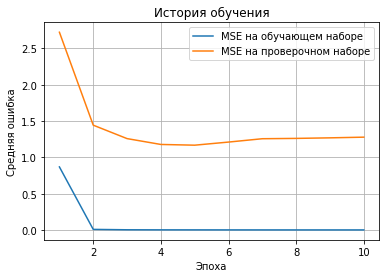

In [ ]:

history = model.fit(xTrain, 
                    yTrain, 
                    epochs=10,
                    batch_size=128,
                    verbose=1,
                    validation_data=(xTest, yTest))
lh.append(history)
lh.plot()

### 4. Возьмите предобученный embedding слой и перегоните все слова из полного словаря в embedding пространство


Наш словарь - это числа от 1 до 50000. Сеть принимает токены блоками по 1000, поэтому преобразуем словарь в двумерный массив:

In [ ]:
ids = np.array([i for i in range(maxWordsCount)]).reshape(-1, xLen)
ids.shape

(50, 1000)

Делаем предикт моделью embed:

In [ ]:
dim = 128
zTrain = embed.predict(ids)
zTrain = zTrain.reshape(-1, dim)
zTrain.shape

(50000, 128)

Получили 50000 векторов размерности 128

### 5. Запустите кластеризацию

Попробуем кластеризовать слова по писателям. 

In [ ]:
km = KMeans(6)
km.fit(zTrain)

pred = km.predict(zTrain)

In [ ]:
pred[:20]

array([3, 3, 2, 5, 0, 0, 4, 1, 3, 2, 2, 1, 0, 1, 4, 2, 2, 4, 3, 4],
      dtype=int32)

Попробуем определить реальное число кластеров

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 


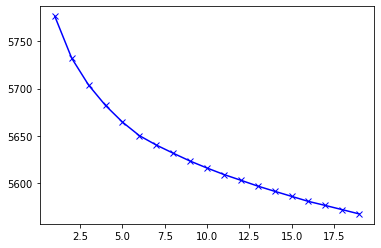

CPU times: user 15min 37s, sys: 1min 23s, total: 17min 1s
Wall time: 15min 17s


In [ ]:
%%time
n_clusters = 20               # Зададим количество кластеров
cost = []                     # Создаем пустой список
for i in range(1, n_clusters): # Пробегаем по списку от 1 до n_clusters
    kmean = KMeans(i)           # Создаем объект KMeans с i-классами
    kmean.fit(zTrain)   # Проводим кластеризацию zTrain
    cost.append(kmean.inertia_) # Добавляем в cost элемент kmean.inertia_
    print(i, end=' ')
print()
  
# inertia_ - это среднее растояние от точек до центров их классов
# Может использоваться для подбора оптимального количества классов 

# Отобразим значения списка cost на графике
plt.plot([i for i in range(1, n_clusters)], cost, 'bx-')
plt.show()

### 6. Выведите устойчивые классы слов

Мы получили очень плавную линию без явно выраженных "локтей". Такой результат говорит о том, что векторы в эмбеддинг-пространстве образуют некоторое единое связное "облако" и не распадаются на ярко выраженные кластеры - "кучки".

Тем не менее можно попробовать разбить все векторы на некоторое произвольное число классов.

In [ ]:
km = KMeans(200)
km.fit(zTrain)

pred = km.predict(zTrain)

In [ ]:
pred[:10]

array([198,  44,  51, 102,  95, 135, 117, 137, 152,  59], dtype=int32)

In [ ]:
voc = [i for i in range(50000)]
voc[:10]

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [ ]:

for i in range(10): # Посмотрим на первые 10 (из 200) кластеров.
    cnt = 0
    print("cluster #%d"%i, end=": ")
    for j in range(50000):
        if pred[j] == i:
            print(tokenizer.index_word[j], end=" ")
            cnt += 1
            if cnt == 20:
                print()
                break


cluster #0: хочешь руками столь например ужас пробормотал девушка давным билл слышали советник бормотал носу попробую тротуара середине побывал страшное впредь госпожи 
cluster #1: четыре повернулся ответ дороги шли разных рассказал стараясь извлек непонятно распахнул темноту красные оглядел бессмысленно собственную фигура дне дважды горел 
cluster #2: миссис никого думать спросила письмо нашем спину принял явился впечатление вашу пошла дорога пусто мартин малыш лета кровать бояться герцога 
cluster #3: времени будем забыл разу дедушка травы кухне ушли порой собака помещение попросить воздуха рождения канцелярии шутки сошел форму расстоянии михаил 
cluster #4: может стоял вслед умер имел большинство радио любое надолго помог всякую уходить надпись согласилась даром набрал получше позвонил мальчишек шкалика 
cluster #5: каких телефон прежнему встал оба дона холма извини больно палец пятьсот собственные бывают долгие накануне большей взялись афины парке уно 
cluster #6: другого сил ох вн

### 7. Проведите для разного числа классов и разной размерности embedding пространства


Поскольку на размерности 128 облако не кластеризовалось, попробуем другую размерность.

Epoch 1/10
138/138 [==============================] - 32s 232ms/step - loss: 0.5468 - accuracy: 0.8537 - val_loss: 1.6520 - val_accuracy: 0.3757
Epoch 2/10
138/138 [==============================] - 32s 230ms/step - loss: 0.0114 - accuracy: 1.0000 - val_loss: 1.4211 - val_accuracy: 0.3802
Epoch 3/10
138/138 [==============================] - 32s 232ms/step - loss: 0.0030 - accuracy: 1.0000 - val_loss: 1.2548 - val_accuracy: 0.4975
Epoch 4/10
138/138 [==============================] - 32s 229ms/step - loss: 0.0016 - accuracy: 1.0000 - val_loss: 1.0994 - val_accuracy: 0.5872
Epoch 5/10
138/138 [==============================] - 32s 231ms/step - loss: 0.0010 - accuracy: 1.0000 - val_loss: 1.0772 - val_accuracy: 0.6140
Epoch 6/10
138/138 [==============================] - 32s 231ms/step - loss: 7.2933e-04 - accuracy: 1.0000 - val_loss: 1.0924 - val_accuracy: 0.6197
Epoch 7/10
138/138 [==============================] - 32s 230ms/step - loss: 5.7442e-04 - accuracy: 1.0000 - val_loss: 1.0929 

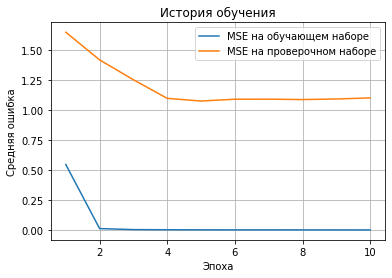

In [ ]:
dim = 256
lh = LearnHistory()
model2, embed2 = createEmbeddingModel(dim=dim)
history = model2.fit(xTrain, 
                    yTrain, 
                    epochs=10,
                    batch_size=128,
                    verbose=1,
                    validation_data=(xTest, yTest))
lh.append(history)
lh.plot()

In [ ]:
zTrain2 = embed2.predict(ids)
zTrain2 = zTrain2.reshape(-1, dim)
zTrain2.shape

(50000, 256)

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 


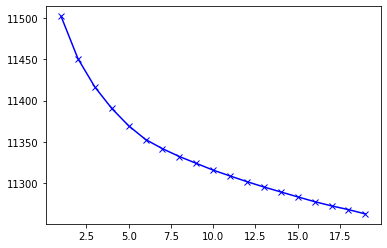

CPU times: user 28min 47s, sys: 2min 16s, total: 31min 3s
Wall time: 28min 8s


In [ ]:
%%time
n_clusters = 20               # Зададим количество кластеров
cost = []                     # Создаем пустой список
for i in range(1, n_clusters): # Пробегаем по списку от 1 до n_clusters
    kmean = KMeans(i)           # Создаем объект KMeans с i-классами
    kmean.fit(zTrain2)   # Проводим кластеризацию zTrain2
    cost.append(kmean.inertia_) # Добавляем в cost элемент kmean.inertia_
    print(i, end=' ')
print()

# Отобразим значения списка cost на графике
plt.plot([i for i in range(1, n_clusters)], cost, 'bx-')
plt.show()

Видим, что после увеличения размерности эмбеддинга в 2 раза картина не изменилась, явных кластеров нет. 

### 8. Выводы

Распределение векторов в эмбеддинг-пространстве не фрагментируется на обособленные "кучки" - кластеры. Если разбить векторы на некоторое произвольно выбранное число групп (например 200), то в одну группу попадают слова совершенно разного смысла, не имеющие ничего общего. 

Я считаю, что причина этого в неудачном выборе признака для классификации. В нашем случае признаков всего 6 (писатели), и классифицировались не отдельные слова, а фрагменты в 1000 слов. Сам же словарь был общим для всех писателей, одно и то же слово может встречаться почти у всех писателей. Поэтому сеть не смогла распознать семантику слов при такой классификации.

Для удачной кластеризации число признаков должно соответствовать числу кластеров (как в случае задания про MNIST), и признаки должны относиться к отдельным словам, а не фрагментам текста.

# PRO задание. Вариант 3
Сделать классификацию цифр mnist, используя только Xtrain (без Ytrain). 

Предобучите автокодировщик.

Возьмите предобученный encoder

Кластеризовать скрытое пространство, полученное из encoder (т.е. Кластеризовать изображения, так как при подаче изображения на вход encoder’у получится скрытое пространство)


In [3]:
(x_train, y_train), (_, _) = mnist.load_data()
X = x_train.astype(np.float32)/255.
X = np.expand_dims(X, -1)
X.shape, X.dtype

11493376/11490434 [==============================] - 0s 0us/step


((60000, 28, 28, 1), dtype('float32'))

## dim = 100

In [4]:
def Autoencoder(shape=(28, 28, 1), latent_dim=100): 
    img_input = Input((shape)) 
    x = Conv2D(64, (3, 3), padding='same', activation='relu')(img_input) 
    x = BatchNormalization()(x) 
    x = Conv2D(64, (3, 3), padding='same', activation='relu')(x) 
    x = BatchNormalization()(x) 
    x = Conv2D(64, (3, 3), padding='same', activation='relu')(x) 
    x = BatchNormalization()(x) 
    x = MaxPooling2D()(x) 

    x = Conv2D(128, (3, 3), padding='same', activation='relu')(x) 
    x = BatchNormalization()(x)  
    x = Conv2D(128, (3, 3), padding='same', activation='relu')(x)  
    x = BatchNormalization()(x) 
    x = Conv2D(128, (3, 3), padding='same', activation='relu')(x)  
    x = BatchNormalization()(x) 
    x = MaxPooling2D()(x) 
    x = Flatten()(x)
    
    z = Dense(latent_dim, name="latent_space")(x)

    x = Dense(7*7*128)(z)
    x = Reshape((7, 7, 128))(x)
    x = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same', activation='relu')(x) 
    x = BatchNormalization()(x) 
    
    x = Conv2D(128, (3, 3), padding='same', activation='relu')(x) 
    x = BatchNormalization()(x) 
    x = Conv2D(128, (3, 3), padding='same', activation='relu')(x) 
    x = BatchNormalization()(x) 
    x = Conv2D(128, (3, 3), padding='same', activation='relu')(x) 
    x = BatchNormalization()(x) 

    x = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same', activation='relu')(x) 
    x = BatchNormalization()(x) 
    x = Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x) 
    x = Conv2D(64, (3, 3), padding='same', activation='relu')(x) 
    x = BatchNormalization()(x) 
    x = Conv2D(64, (3, 3), padding='same', activation='relu')(x) 
    x = BatchNormalization()(x) 

    out = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

    model = Model(img_input, out) 
    encoder = Model(img_input, z)

    model.compile(optimizer=Adam(lr=0.0001), loss='mean_squared_error') 

    return model, encoder

In [23]:
ae, enc = Autoencoder((28, 28, 1))
lh = LearnHistory()

In [24]:
ae.summary()

Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 28, 28, 64)        640       
_________________________________________________________________
batch_normalization_14 (Batc (None, 28, 28, 64)        256       
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 28, 28, 64)        36928     
_________________________________________________________________
batch_normalization_15 (Batc (None, 28, 28, 64)        256       
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 28, 28, 64)        36928     
_________________________________________________________________
batch_normalization_16 (Batc (None, 28, 28, 64)       

In [25]:
history = ae.fit(X, X, epochs=20, batch_size=300, validation_split=0.1)

Epoch 1/20
180/180 [==============================] - 10s 54ms/step - loss: 0.0751 - val_loss: 0.1030
Epoch 2/20
180/180 [==============================] - 10s 53ms/step - loss: 0.0255 - val_loss: 0.0761
Epoch 3/20
180/180 [==============================] - 10s 53ms/step - loss: 0.0106 - val_loss: 0.0126
Epoch 4/20
180/180 [==============================] - 10s 53ms/step - loss: 0.0072 - val_loss: 0.0079
Epoch 5/20
180/180 [==============================] - 9s 53ms/step - loss: 0.0057 - val_loss: 0.0080
Epoch 6/20
180/180 [==============================] - 9s 53ms/step - loss: 0.0049 - val_loss: 0.0061
Epoch 7/20
180/180 [==============================] - 10s 53ms/step - loss: 0.0043 - val_loss: 0.0053
Epoch 8/20
180/180 [==============================] - 9s 53ms/step - loss: 0.0039 - val_loss: 0.0042
Epoch 9/20
180/180 [==============================] - 10s 53ms/step - loss: 0.0036 - val_loss: 0.0041
Epoch 10/20
180/180 [==============================] - 9s 53ms/step - loss: 0.0033 - 

Сравним выход и вход автоэнкодера

In [26]:
pred = ae.predict(X)

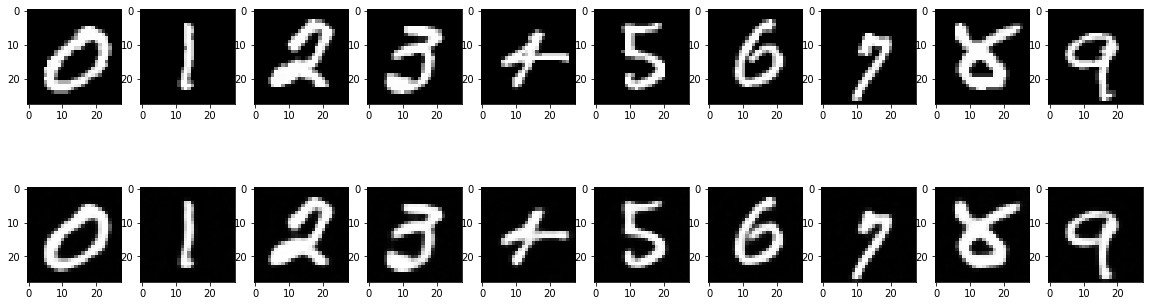

In [27]:
plt.figure(figsize=(20,6))
shift = np.random.randint(1000)
for i in range(10):
    plt.subplot(2, 10, 1+i)
    plt.imshow(X[y_train == i][shift].reshape(28,28), cmap='gray')
    plt.subplot(2, 10, 11+i)
    plt.imshow(pred[y_train == i][shift].reshape(28,28), cmap='gray')
plt.show()

Выведем все векторы в скрытом пространстве

In [39]:
z_train = enc.predict(X)
z_train.shape, z_train.std()

((60000, 100), 7.265688)

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 


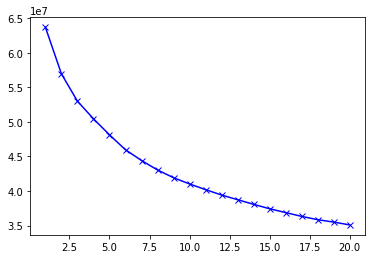

CPU times: user 6min 10s, sys: 1min 32s, total: 7min 43s
Wall time: 5min 52s


In [ ]:
%%time
n_clusters = 20               # Зададим количество кластеров
cost = []                     # Создаем пустой список
for i in range(1, n_clusters+1): # Пробегаем по списку от 1 до n_clusters
    kmean = KMeans(i)           # Создаем объект KMeans с i-классами
    kmean.fit(z_train)   # Проводим кластеризацию z_train
    cost.append(kmean.inertia_) # Добавляем в cost элемент kmean.inertia_
    print(i, end=' ')
print()

# Отобразим значения списка cost на графике
plt.plot([i for i in range(1, n_clusters+1)], cost, 'bx-')
plt.show()

Кривая величины inertia_ не показала явной кластеризации на 10 кластеров.

In [40]:
km = KMeans(10)
km.fit(z_train)

pred = km.predict(z_train)
print(homogeneity_score(y_train, pred))

0.5148530212844681


Метрика [homogeneity_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.homogeneity_score.html) показала 51% совпадение меток с кластерами, найденными методом KMeans

## dim = 2

Попробуем уменьшить размерность скрытого пространства с 100 до 2. Это ухудшит точность воспроизведения автоэнкодера, но зато позволит наглядно визуализировать результаты.

In [31]:
ae2, enc2 = Autoencoder((28, 28, 1), latent_dim=2)
lh = LearnHistory()

In [32]:
history = ae2.fit(X, X, epochs=20, batch_size=300, validation_split=0.1)

Epoch 1/20
180/180 [==============================] - 10s 54ms/step - loss: 0.0924 - val_loss: 0.0992
Epoch 2/20
180/180 [==============================] - 9s 53ms/step - loss: 0.0608 - val_loss: 0.0900
Epoch 3/20
180/180 [==============================] - 10s 53ms/step - loss: 0.0503 - val_loss: 0.0580
Epoch 4/20
180/180 [==============================] - 9s 53ms/step - loss: 0.0459 - val_loss: 0.0449
Epoch 5/20
180/180 [==============================] - 9s 52ms/step - loss: 0.0446 - val_loss: 0.0435
Epoch 6/20
180/180 [==============================] - 9s 53ms/step - loss: 0.0438 - val_loss: 0.0430
Epoch 7/20
180/180 [==============================] - 9s 52ms/step - loss: 0.0432 - val_loss: 0.0425
Epoch 8/20
180/180 [==============================] - 9s 52ms/step - loss: 0.0428 - val_loss: 0.0426
Epoch 9/20
180/180 [==============================] - 9s 52ms/step - loss: 0.0425 - val_loss: 0.0430
Epoch 10/20
180/180 [==============================] - 9s 52ms/step - loss: 0.0421 - val_

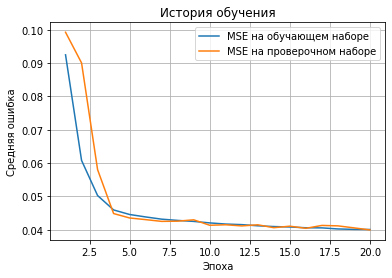

In [33]:
lh.append(history)
lh.plot()

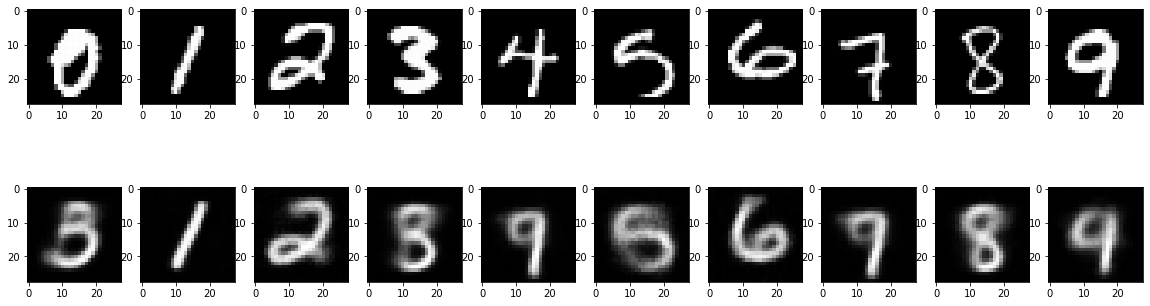

In [34]:
pred = ae2.predict(X)

plt.figure(figsize=(20,6))
shift = np.random.randint(1000)
for i in range(10):
    plt.subplot(2, 10, 1+i)
    plt.imshow(X[y_train == i][shift].reshape(28,28), cmap='gray')
    plt.subplot(2, 10, 11+i)
    plt.imshow(pred[y_train == i][shift].reshape(28,28), cmap='gray')
plt.show()

Видим, что малая размерность скрытого пространства сделала выход автоэнкодера размытым.

In [35]:
z_train = enc2.predict(X)

Попробуем обнаружить кластеры

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 


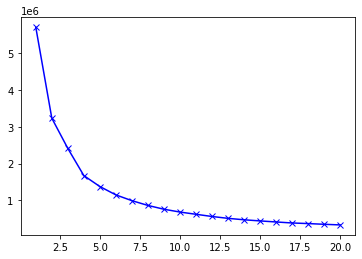

CPU times: user 52.2 s, sys: 315 ms, total: 52.5 s
Wall time: 52.5 s


In [ ]:
%%time
n_clusters = 20               # Зададим количество кластеров
cost = []                     # Создаем пустой список
for i in range(1, n_clusters+1): # Пробегаем по списку от 1 до n_clusters
    kmean = KMeans(i)           # Создаем объект KMeans с i-классами
    kmean.fit(z_train)   # Проводим кластеризацию z_train
    cost.append(kmean.inertia_) # Добавляем в cost элемент kmean.inertia_
    print(i, end=' ')
print()

# Отобразим значения списка cost на графике
plt.plot([i for i in range(1, n_clusters+1)], cost, 'bx-')
plt.show()

Опять кривая показывает отсутствие выраженной кластеризации.

Посмотрим как в двумерном скрытом пространстве расположились цифры (используя метки y_train): 

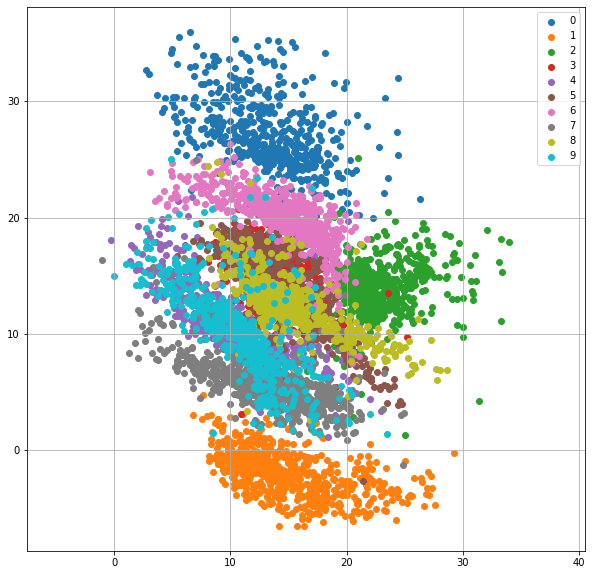

In [ ]:
z1 = z_train[::10]
y1 = y_train[::10]
plt.figure(figsize=(10, 10))
[plt.scatter(z1[y1==i, 0], z1[y1==i, 1], label='%d'%i) for i in range(10)]
plt.axis('equal')
plt.legend()
plt.grid()
plt.show()

Мы видим, что точкам явно тесно, разные классы плотно прижаты друг к другу и сильно пересекаются.

Еще одна особенность - точки не группируются вокруг начала координат (0, 0), а достаточно сильно смещены в сторону положительных значений. Я думаю это следствие использования ReLU. При использовании активации tanh картинка, вероятно будет более симметричной относительно начала координат.

Теперь сделаем кластеризацию на 10 классов и сравним результат:

In [37]:
km = KMeans(10)
km.fit(z_train)

pred = km.predict(z_train)
print(homogeneity_score(y_train, pred))

0.48080978615562214


Метрика [homogeneity_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.homogeneity_score.html) показала 48% совпадение меток с кластерами, найденными методом KMeans

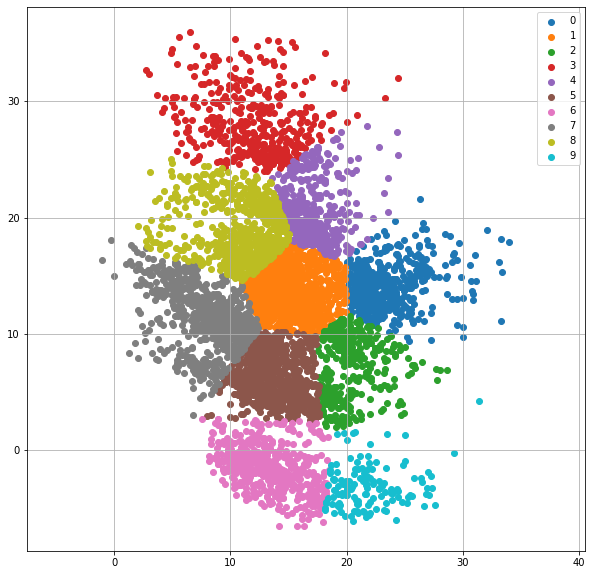

In [ ]:
z1 = z_train[::10]
y2 = pred[::10]
plt.figure(figsize=(10, 10))
[plt.scatter(z1[y2==i, 0], z1[y2==i, 1], label='%d'%i) for i in range(10)]
plt.axis('equal')
plt.legend()
plt.grid()
plt.show()

Конечно нумерация полученных кластеров не совпадает с цифрами (это естественно), но даже с учетом этого видим, что разбивка на кластеры не совпадает с истинными кластерами, соответствующим цифрам. 

## dim = 12

In [5]:
ae3, enc3 = Autoencoder((28, 28, 1), latent_dim=12)
lh = LearnHistory()

Epoch 1/20
180/180 [==============================] - 10s 54ms/step - loss: 0.0821 - val_loss: 0.1045
Epoch 2/20
180/180 [==============================] - 9s 53ms/step - loss: 0.0354 - val_loss: 0.0809
Epoch 3/20
180/180 [==============================] - 9s 53ms/step - loss: 0.0232 - val_loss: 0.0305
Epoch 4/20
180/180 [==============================] - 9s 53ms/step - loss: 0.0171 - val_loss: 0.0151
Epoch 5/20
180/180 [==============================] - 9s 53ms/step - loss: 0.0140 - val_loss: 0.0139
Epoch 6/20
180/180 [==============================] - 9s 52ms/step - loss: 0.0128 - val_loss: 0.0131
Epoch 7/20
180/180 [==============================] - 9s 52ms/step - loss: 0.0121 - val_loss: 0.0120
Epoch 8/20
180/180 [==============================] - 9s 52ms/step - loss: 0.0116 - val_loss: 0.0115
Epoch 9/20
180/180 [==============================] - 9s 52ms/step - loss: 0.0110 - val_loss: 0.0116
Epoch 10/20
180/180 [==============================] - 9s 52ms/step - loss: 0.0107 - val_l

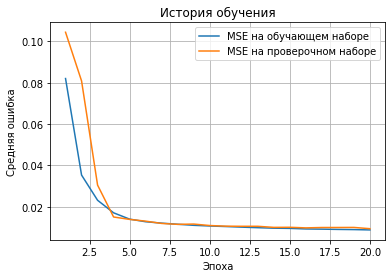

In [6]:
history = ae3.fit(X, X, epochs=20, batch_size=300, validation_split=0.1)
lh.append(history)
lh.plot()

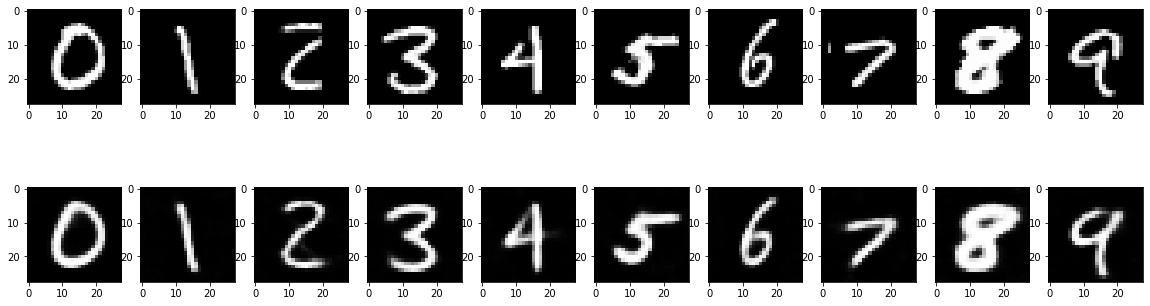

In [7]:
pred = ae3.predict(X)

plt.figure(figsize=(20,6))
shift = np.random.randint(1000)
for i in range(10):
    plt.subplot(2, 10, 1+i)
    plt.imshow(X[y_train == i][shift].reshape(28,28), cmap='gray')
    plt.subplot(2, 10, 11+i)
    plt.imshow(pred[y_train == i][shift].reshape(28,28), cmap='gray')
plt.show()

Видно, что размерности 12 достаточно для почти идеальной рабты.

In [10]:
z_train3 = enc3.predict(X)

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 


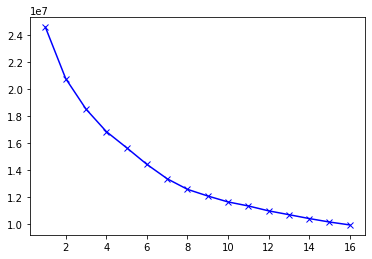

CPU times: user 59.9 s, sys: 18.6 s, total: 1min 18s
Wall time: 59.8 s


In [11]:
%%time
n_clusters = 16               # Зададим количество кластеров
cost = []                     # Создаем пустой список
for i in range(1, n_clusters+1): # Пробегаем по списку от 1 до n_clusters
    kmean = KMeans(i)           # Создаем объект KMeans с i-классами
    kmean.fit(z_train3)   # Проводим кластеризацию z_train
    cost.append(kmean.inertia_) # Добавляем в cost элемент kmean.inertia_
    print(i, end=' ')
print()

# Отобразим значения списка cost на графике
plt.plot([i for i in range(1, n_clusters+1)], cost, 'bx-')
plt.show()

In [22]:
km = KMeans(10)
km.fit(z_train3)

pred = km.predict(z_train3)
print(homogeneity_score(y_train, pred))

0.6915502411514443


Метрика [homogeneity_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.homogeneity_score.html) показала 69% совпадение меток с кластерами, найденными методом KMeans

## ВЫВОДЫ

Эксперименты показали, что точки в двумерном скрытом пространстве не группируются в ярко выраженные кластеры - то есть между кластерами нет пустот, классы тесно прижаты друг к другу. 
